In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor

#### Imports for Bagging and Random Forest

In [4]:
from sklearn.utils import resample

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Ensemble Methods

* Combine models to improve predication/classification performance of a learning method 
    - Overcome overfitting and stability problem of decision trees
* Generate many models that learn independently and then combine into a single prediction/classification
* They are general purpose methods that can be applied to any type of learning model
* They have been very successful when applied to trees
* Methods
    * Averaging
        - Bagging/Random Forests
    * Boosting (sequential build)
        - ADABoost, Gradient Boosting

##  Bagging (Bootstrap Aggregation)
 
* General-purpose procedure for reducing the variance of a statistical learning method
    - Used with decision trees to improve prediction accuracy
        - Grow full trees which will have low bias and high variance
        - Average the results to reduce the variance
    - Averaging independent training sets reduces the variance
       
    
$$ \text{Let }Z_1,Z_2,...,Z_n\text{ be a set of n independent observations each with variance }\sigma^2$$
$$Var(\bar{Z}) = \frac{\sigma^2}{n}$$
 

In [5]:
np.random.seed(42)

variance = 100

def calc_var(n,v):
    # generate datasets
    Z = [stats.norm.rvs(0,np.sqrt(v),size = n) for i in range(1000)]
    # calculate variance of averaged datasets
    v_ = np.var([np.mean(z) for z in Z])
    print(f'Variance of {n} observations with variance = {v}, {v}/{n} = {v_}')

calc_var(10,variance)
calc_var(100,variance)


Variance of 10 observations with variance = 100, 100/10 = 9.849991509472208
Variance of 100 observations with variance = 100, 100/100 = 1.0748006644954218


### Variance in Decision Trees

#### Generate some data

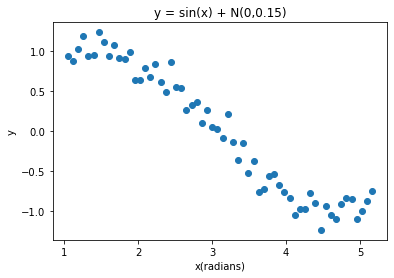

In [6]:
np.random.seed(42)
x = np.array([i*np.pi/180 for i in range(60,300,4)]) # radians 60-300 degrees
# Generate some nonlinear data, y = sin(x) + noise
y = np.sin(x) + np.random.normal(0,0.15,len(x)) # Add some noise to sin function
plt.plot(x,y,'o')
plt.xlabel('x(radians)')
plt.ylabel('y')
plt.title('y = sin(x) + N(0,0.15)');

#### Create 3rd degree polynomial to model y

In [7]:
# 3rd-degree polynomial, x + x**2 + x**3
X = np.array([x**(n+1) for n in range(3)]).T 
# Rows of Nth degree polynomial for 60 data points on the x-axis
print(X.shape)
X[0,:]

(60, 3)


array([1.04719755, 1.09662271, 1.14838062])

#### Variance in trees versus linear regression

In [8]:
dt = DecisionTreeRegressor(random_state = 1234)
lr = LinearRegression()

#### Show that trees are more variable than Linear Regression (i.e. more sensitive to small changes in the data)

* Predict x = 3.5 for N different datasets (i.e. different y generated for each iteration)


In [9]:
x_pred = np.array([3.5,3.5**2,3.5**3]).reshape(1,3)
N = 10
yhats = []
yhats_lr = []
mses = []
mses_lr = []
y_ = y
for i in range(N):
    dt.fit(X, y_)
    lr.fit(X,y_)
    yhats.append(dt.predict(x_pred))
    yhats_lr.append(lr.predict(x_pred))
    mses.append(np.mean(y_ - yhats)**2)
    mses_lr.append(np.mean(y_ - yhats_lr)**2)
    y_ = np.sin(x) + np.random.normal(0,0.15,len(y)) # new sample data
    

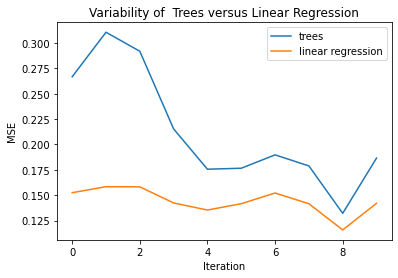

In [10]:
plt.plot(range(len(mses)),mses)
plt.plot(range(len(mses_lr)),mses_lr)
plt.legend(('trees','linear regression'))
plt.title('Variability of  Trees versus Linear Regression')
plt.xlabel('Iteration')
plt.ylabel('MSE');

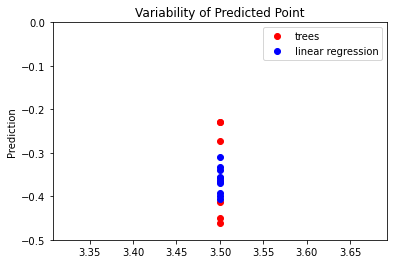

In [11]:

plt.plot([3.5]*len(yhats),yhats,'ro')
plt.plot([3.5]*len(yhats_lr),yhats_lr,'bo')
plt.ylim((-.5,0))
plt.title('Variability of Predicted Point')
plt.legend(('trees','linear regression'))
plt.ylabel('Prediction');

## The Bootstrap

* Bradley Efron, 1979

* Widely applicable method to quantify uncertainty associated with a given estimator or learning method
    - Used when measure of variability is difficult to obtain
    - It does not improve the point estimate of a parameter

* Often we are not able to keep getting different samples of the population.
    - Can use the Bootstrap to "simulate the different samples" 
    
* A bootstrap sample is a random sample taken **with replacement** from the original sample, of the same size as the original sample
    - sklearn provides a function for this (called resample)
    - http://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

![](Bootstrap.png)
$$\text{Figure 1. Bootstrap Generation, Sample with Replacement}$$

In [12]:

np.random.seed(1234)

N = 10000
sample_size = 100

# Sampling distribution of the mean

# N samples of size 100
dist1 = [np.mean(stats.norm.rvs(size = sample_size)) for i in range(N)] 


# 1 sample of size 100, resampled N timesfrom sklearn.utils import resample
Z = stats.norm.rvs(size = sample_size)
dist2 = [np.mean(resample(Z)) for i in range(N)] 


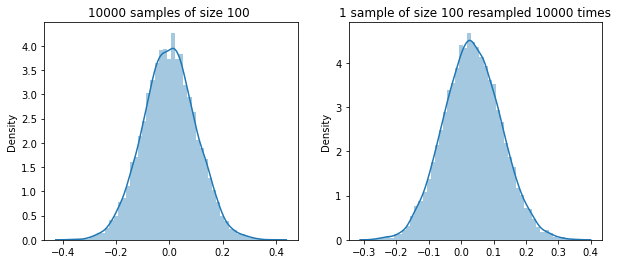

In [13]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
sns.distplot(dist1,ax=ax1)
ax1.set_title(f'{N} samples of size {sample_size} ')
sns.distplot(dist2,ax=ax2)
ax2.set_title(f'1 sample of size {sample_size} resampled {N} times');

### Bagging method  
 
* Since don't generally have access to independent training sets, use bootstrap on single training set
* Generate B different bootstrapped training data sets
* Train our method on the bth bootstrapped training to get a prediction (i.e. fit a tree to each bootstrap sample)
 
#### For regression trees
 
* Average the predictions

<div style="font-size: 110%;">
$$\hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^B\hat{f}^{*b}(x)$$
</div>
* where $\hat{f}^{*b}(x)$ is the prediction at point x

#### For classification trees

* For each test observation record the class predicted by each if the B trees
* Take a majority vote

#### Out-of-bag (OOB) Error estimation
  
* Natural way to estimate test error without a validation set or cross-validation
* Each bagged tree makes use of around two-thirds of the observations.
* Out-of-bag observations: the remaining one-third
* Predict the response for the ith observation using each of the trees in which that observation was OOB. 
* Average the approximately B/3 predictions for the ith observation
    - essentially the Leave-One-Out cross-validation error for bagging
 
#### Variable Importance
 
* Aggregation improves prediction accuracy but makes interpretability harder
* But can obtain an overall summary of the importance of each predictor
* For regression: Average the total amount that the MSE or MAE is decreased due to splits over a given predictor
    - A large value indicates an important predictor. 
* For classification: Use Gini or Entropy instead of MSE or MAE
 
### Bagging will be a special case of Random Forests
 
* Uses same function as Random Forest using all the predictors
    

### Bagging in sklearn


http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

#### Parameters

* n_estimators: number of trees in the forest
* max_features: number of features to consider at each split. For bagging all the features are considered
* criterion: 'mse' or 'mae'
* max_depth: control size by limiting tree depth
* min_samples_split: minimum # of samples required to split an internal node
* min_samples_leaf: control size by setting minimum number of samples at leaf nodes
* random_state: The features are always randomly permuted at each split. To obtain a deterministic behavior during fitting, set random_state.
* ccp_alpha:Minimum cost-complexity pruning parameter

#### Compare Variance of bagged trees to regular decision trees

In [14]:
np.random.seed(42)

dt = DecisionTreeRegressor(random_state = 1234)
bt = RandomForestRegressor(n_estimators = 10, random_state = 1234)


In [15]:
bt.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [16]:
N = 10
yhats = []
yhats_bt = []
mses = []
mses_bt = []
y_ = y
for i in range(1,N):
    dt.fit(X, y_)
    bt.fit(X,y_)
    yhats.append(dt.predict(x_pred))
    yhats_bt.append(bt.predict(x_pred))
    mses.append(np.mean(y_ - yhats)**2)
    mses_bt.append(np.mean(y_ - yhats_bt)**2)
    y_ = np.sin(x) + np.random.normal(0,0.15,len(y)) # new sample data
    

In [17]:
bt.n_features_

3

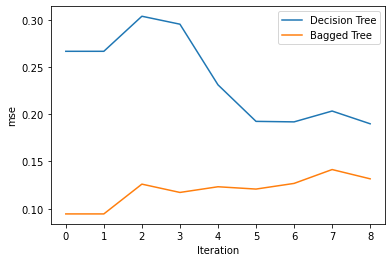

In [18]:
plt.plot(range(len(mses)),mses)
plt.plot(range(len(mses_bt)),mses_bt)
plt.legend(('Decision Tree','Bagged Tree'))
plt.xlabel('Iteration')
plt.ylabel('mse');

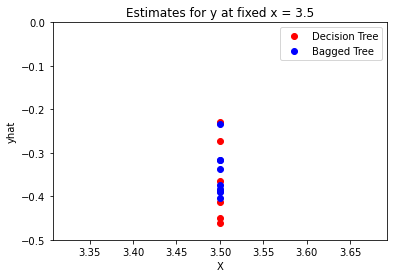

In [19]:
plt.plot([3.5]*len(yhats),yhats,'ro')
plt.plot([3.5]*len(yhats_bt),yhats_bt,'bo')
plt.ylim((-.5,0))
plt.legend(('Decision Tree','Bagged Tree'))
plt.title("Estimates for y at fixed x = 3.5")
plt.xlabel("X")
plt.ylabel("yhat");

#### Bagged tree regression  on Boston data

In [20]:
Boston = pd.read_csv("Boston.csv")
Boston.tail()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


In [21]:
X = Boston.iloc[:, 0:13].values
y = Boston.loc[:, 'medv'].values 

# Validation Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((379, 13), (127, 13), (379,), (127,))

In [22]:
# Fit random Forest to Training data
model = RandomForestRegressor(n_estimators = 100, max_features = 13,random_state = 1234)
model.fit(X_train, y_train)

# Predict the Test data
y_pred = model.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
print("Test error is: ",mse)
print(f'R^2 is {model.score(X_test,y_test)}')

Test error is:  16.44091315748032
R^2 is 0.7987624077312065


In [23]:
feats = Boston.columns.tolist()[:-1] # All the features
vals = model.feature_importances_
pairs = [(vals[i],feats[i]) for i in range(len(vals))]
pairs.sort(reverse=True)
print('Feature Importances')
for val,feat in pairs:
 print(feat,'\t',round(val,6))


Feature Importances
rm 	 0.451415
lstat 	 0.385433
dis 	 0.038107
crim 	 0.037079
ptratio 	 0.024009
tax 	 0.017041
nox 	 0.014829
age 	 0.011095
black 	 0.008508
indus 	 0.007977
rad 	 0.00313
zn 	 0.000986
chas 	 0.000391


In [ ]:
scores = cross_val_score(estimator = RandomForestRegressor(n_estimators = 100, max_features = 13), 
                         X = X_train, y = y_train, cv = 10)
plt.plot(range(1,11),scores,"o-")
plt.title('Cross Validation Scores')
print("Mean accuracy: ",scores.mean())

### Bagged Tree Classification

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### Parameters

* n_estimators: number of trees in the forest
* max_features: number of features to consider at each split. For bagging all the features are considered
* criterion: 'gini' or 'entropy'
* max_depth: control size by limiting tree depth
* min_samples_split: minimum # of samples required to split an internal node
* min_samples_leaf: control size by setting minimum number of samples at leaf nodes
* random_state: The features are always randomly permuted at each split. To obtain a deterministic behavior during fitting, set random_state.
* ccp_alpha:Minimum cost-complexity pruning parameter


In [ ]:
# Random Forest Classification

Wine = pd.read_csv("Wine.csv")
feats = Wine.columns[0:-1]
print(len(feats))
Wine.head()

In [ ]:
X = Wine.iloc[:, 0:13].values
y = Wine.iloc[:, 13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size = 0.25, 
                                                    random_state = 1234)

In [ ]:
model = RandomForestClassifier(n_estimators = 10, criterion = 'gini', max_features=13, random_state = 1234)
model.fit(X_train, y_train)

In [ ]:
# Predict the test data
y_pred = model.predict(X_test)

# Make the Confusion Matrix and calculate accuracy
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm)/np.sum(cm)
print("Accuracy is: ", np.round(accuracy,3))



In [ ]:
feats = Wine.columns.tolist()[:-1] # All the features
vals = model.feature_importances_
pairs = [(vals[i], feats[i]) for i in range(len(feats))]
# Sort from high to low
pairs.sort(reverse=True)
for val,feat in pairs:
    print(feat,'\t',round(val,3))

## Random Forests

* Leo Breiman (2001)
    - He was instrumental in bridging the gap between Statistics and Computer Science in Machine Learning
* Improvement over bagged trees by way of a small tweak that decorrelates the trees. 
 
    - This reduces the variance when we average the trees.
 
* Each time a split in a tree is considered, a random selection of m predictors is chosen as split candidates from the full set of p predictors. 
 
    - For Classification, choose $m \approx{\sqrt{p}}$
 
    - For Regression p / 3
 

### Random Forest Regression in sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
X = Boston.iloc[:, 0:13].values
y = Boston.iloc[:, 13].values

# Validation Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Fit random Forest to Training data
# For regression use p/3 predictors
num_feats = int(X_train.shape[1]/3)
model = RandomForestRegressor(n_estimators = 100, max_features = num_feats, random_state = 1234)
model.fit(X_train, y_train)

In [ ]:
# Predict the Test data
y_pred = model.predict(X_test)
mse = np.mean((y_pred - y_test)**2)
print("Test error is: ",mse)
print(f'R^2 is {model.score(X_test,y_test)}')

In [ ]:
feats = Boston.columns.tolist()[:-1] # All the features
vals = model.feature_importances_
pairs = [(vals[i], feats[i]) for i in range(len(feats))]
# Sort from high to low
pairs.sort(reverse=True)
for val,feat in pairs:
    print(feat,'\t',round(val,3))

### Random Forest Classification in sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
X = Wine.iloc[:, 0:13].values
y = Wine.iloc[:, 13].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size = 0.25, 
                                                    random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
num_feats = int(np.sqrt(X_train.shape[1]))
model = RandomForestClassifier(n_estimators = 10, criterion = 'gini', 
                               max_features = num_feats, random_state = 1234)
model.fit(X_train, y_train)

In [ ]:
# Predict the test data
y_pred = model.predict(X_test)

# Make the Confusion Matrix and calculate accuracy
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = np.trace(cm)/np.sum(cm)
print("Accuracy is: ", np.round(accuracy,3))



In [ ]:
feats = Wine.columns.tolist()[:-1] # All the features
vals = model.feature_importances_
pairs = [(vals[i], feats[i]) for i in range(len(feats))]
# Sort from high to low
pairs.sort(reverse=True)
print('Feature Importances')
for val,feat in pairs:
    print(feat,'\t',round(val,3))

### Grid Search

In [ ]:
# Grid Search Python
# Applying Grid Search to find the best model and the best parameters

parameters = [{'n_estimators': [10, 100,500], 'max_features': [3,4,5,6],'criterion':['gini','entropy']}]
grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           iid = 'False',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best accuracy: ", best_accuracy)
print("Best parameters: ", best_parameters )

### Exercises

#### 1)  Bootstrap

Given the code below create two distributions:  
Distribution 1: Sampling Distribution of the Mean  
Distribution 2: Bootstrap means.

Display the distributions 

In [ ]:
np.random.seed(1234)
N = 10000 #Number of samples in distribution
sample_size = 100

Population = np.random.randint(1,100,size=1000)

def sample_pop(sample_size):
    return np.random.choice(Population,sample_size)

In [ ]:
# Your Code Here


#### 2) RandomForest  regression 

Using the data above from the Hitters dataset.  
Do a grid search for the best parameters of a RandomForestRegressor  estimator.  
Create a  RandomForestRegressor model with the best parameters  
Output the test data R-squared and MSE.

### Hitters dataset

In [ ]:
feats = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
         'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Hitters = pd.read_csv('Hitters.csv')
Hitters = Hitters.dropna()
Hitters.head()


In [ ]:
X = Hitters.loc[:, feats].values
y = Hitters.loc[:, 'Salary'].values

# Make Validation Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Your Code Here

#### Figures

Figures 1 in this presentation are taken from "An Introduction to Statistical Learning, with applications in R" (Springer, 2013) with permission from the authors: G. James, D. Witten, T. Hastie and R. Tibshirani 